# Вебинар 4. Рекоммендательные системы на основе контента. Поиск похожих товаров и пользователей

---

In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.bpr import BayesianPersonalizedRanking
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [2]:
data = pd.read_csv('../Lecture_2/webinar_2/webinar_2/data/transaction_data.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
def get_recommendations(user, model, N=5):
    if user not in userid_to_id:
        user = random.choice(list(userid_to_id.keys()))

    res = [id_to_itemid[rec[0]] for rec in
           model.recommend(userid=userid_to_id[user],
                           user_items=csr_matrix(user_item_matrix).tocsr(),  # на вход user-item matrix
                           N=N,
                           filter_already_liked_items=False,
                           filter_items=[itemid_to_id[999999]],  # !!!
                           recalculate_user=True)]
    return res

In [4]:
def get_rec(model, x):
    n = 2
    while True:
        recs = model.similar_items(itemid_to_id[x], n)
        top_rec = recs[n - 1][0]
        if id_to_itemid[top_rec] != 999999:
            break
        else:
            n += 1
    return id_to_itemid[top_rec]

In [5]:
item_features = pd.read_csv(
    'C:/Users/Вадим/Desktop/GeekBrains/Recommendation-systems/Lectures/Lecture_2/webinar_2/webinar_2'
    '/data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

In [6]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [7]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns = ['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65..."
1,3,"[823704, 834117, 840244, 913785, 917816, 93870..."


In [8]:
n_items_before = data_train['item_id'].nunique()

data_train, top_n = prefilter_items(data_train, item_features, take_n_popular=5000)

n_items_after = data_train['item_id'].nunique()

In [9]:
user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id', columns='item_id',
                                  values='quantity',  # Можно пробоват ьдругие варианты
                                  aggfunc='count',
                                  fill_value=0
                                  )

user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit

user_item_matrix.head(3)

item_id,42346,43020,244960,818981,819400,819487,819549,819590,819969,820011,...,16729299,16729363,16734419,16769526,16770147,16770156,16809649,17104444,17105058,17179856
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [11]:
n_items_before, n_items_after

(90386, 5001)

In [12]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице !

In [13]:
model = AlternatingLeastSquares(factors=128,
                                regularization=0.001,
                                iterations=15,
                                calculate_training_loss=True,
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

In [14]:
result['bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['bm25'], row['actual']), axis=1).mean()

0.10919136112506213

In [15]:
result.head(2)

,user_id,actual,bm25
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[9297615, 877391, 5577022, 898121, 1088462]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1008714, 9677270, 933248, 12132312, 9296795]"


----

# Альтернативные способы предсказаний

### Кейс 1. Продажи товаров собственной торговой марки (СТМ)

У многих ритейлеров есть товары СТМ:
    - Азбука Вкуса - Просто Азбука
    - Ашан - Каждый день
    - ВкусВилл - ВкусВилл
    - ...
    
Как правило, у них маржинальность (~прибыль) > обычные товары.   
Как сделать так, чтобы юзеры переключились на товары СТМ? - *рекоммендации!*

*Нужно заменить те товары, которые пользователь уже покупает, на товары СТМ*

In [16]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [17]:
len(itemid_to_id)

5001

In [18]:
itemid_to_id[999_999]

1891

Отберём в item_features только те товары, которые мы имеем в data_train

In [19]:
item_features = item_features[item_features['item_id'].isin(itemid_to_id.keys())]
item_features[item_features['brand'] == 'Private'].item_id.nunique()

692

В item_features имеем 692 товара собственной торговой марки различного назначения.

In [20]:
own_items = item_features[item_features['brand'] == 'Private'].groupby('department')['item_id'].nunique().\
    sort_values(ascending=False)
own_items

department
GROCERY          407
DRUG GM           81
MEAT-PCKGD        51
SEAFOOD-PCKGD     43
DELI              40
PASTRY            39
NUTRITION         12
PRODUCE            9
MEAT               5
FLORAL             3
COSMETICS          1
SEAFOOD            1
Name: item_id, dtype: int64

Самая представительная группа собстенной торговой марки - GROCERY (бакалея) - 407 наименований, за ней следует группа DRUG GM - 81 наименования и т.д.

In [21]:
categories_with_own_items = own_items.index.tolist()

In [22]:
categories_with_own_items

['GROCERY',
 'DRUG GM',
 'MEAT-PCKGD',
 'SEAFOOD-PCKGD',
 'DELI',
 'PASTRY',
 'NUTRITION',
 'PRODUCE',
 'MEAT',
 'FLORAL',
 'COSMETICS',
 'SEAFOOD']

In [23]:
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

In [24]:
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42, n_iter=300, n_iter_without_progress=20)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames)

In [25]:
def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [26]:
model.item_factors.shape

(5001, 128)

In [27]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [28]:
len(category)

5001

J:\Vadim\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


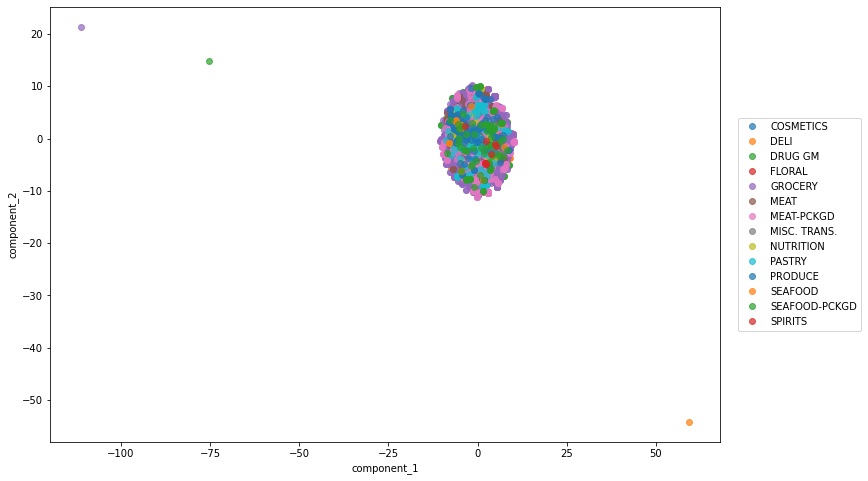

CPU times: total: 2min 16s
Wall time: 12.9 s


In [29]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne')
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne['item_id'] = list(itemid_to_id.keys())
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

In [30]:
condition_cat = (item_emb_tsne['category'] != 'DRUG GM') & (item_emb_tsne['category'] != 'GROCERY')

In [31]:
item_emb_tsne_reduced = item_emb_tsne[condition_cat]

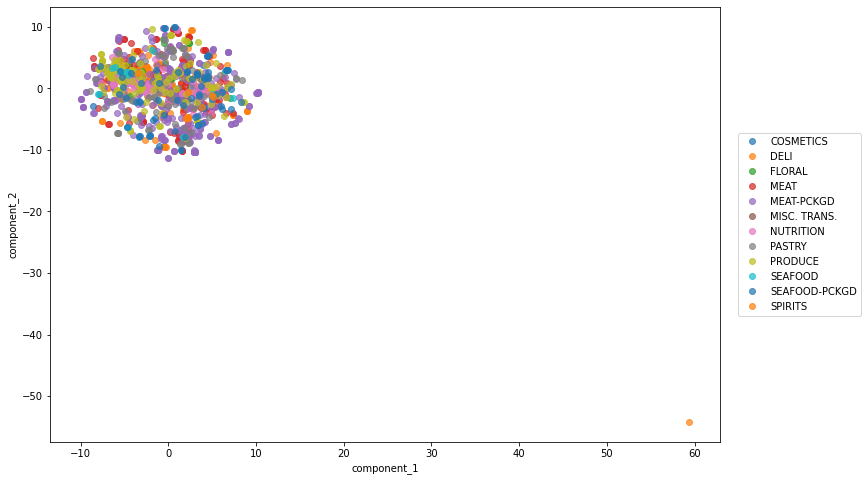

In [32]:
display_components_in_2D_space(item_emb_tsne_reduced, labels='category')

Нарисуем все товары в катгеориях, где есть СТМ

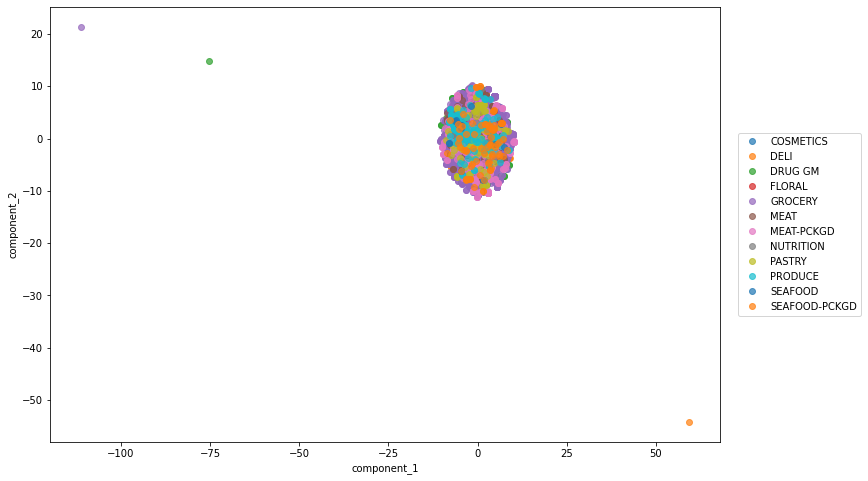

In [33]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(categories_with_own_items)], 
                               labels='category')

In [35]:
similar_items = model.similar_items(itemid_to_id[820352], N=50)
similar_items[:10]

[(13, 1.0000001),
 (765, 0.7123864),
 (480, 0.6792782),
 (1891, 0.67755026),
 (3240, 0.6649901),
 (3577, 0.66460073),
 (2444, 0.6619406),
 (4996, 0.6589744),
 (3408, 0.65684646),
 (1885, 0.6551175)]

In [36]:
similar_items = [id_to_itemid[sim[0]] for sim in similar_items]
similar_items[:10]

[820352,
 894357,
 867008,
 999999,
 1130951,
 6396558,
 1057231,
 16770156,
 5567486,
 999375]

In [37]:
similar_items.append(820352)

In [39]:
item_emb_tsne[item_emb_tsne['item_id'] == 820352]

,component_1,component_2,category,item_id
13,8.801096,-4.976442,DRUG GM,820352


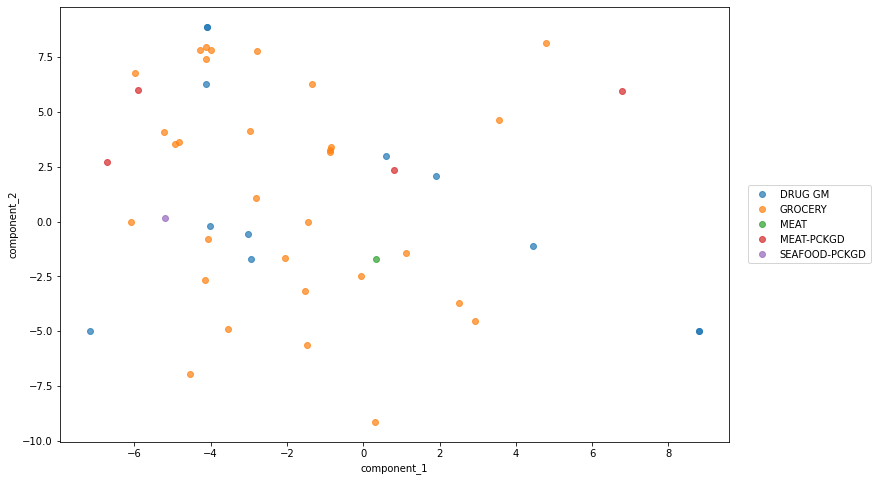

In [40]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['item_id'].isin(similar_items)], 
                               labels='category')

Берем топ-5 популярных покупок юзера --> находим по 1 наиболее близкому товару СТМ для них --> рекомендуем

In [41]:
popularity = data_train.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
popularity.sort_values('quantity', ascending=False, inplace=True)

popularity = popularity[popularity['item_id'] != 999999]
popularity = popularity.groupby('user_id').head(5)
popularity.sort_values('user_id', ascending=False, inplace=True)


,user_id,item_id,quantity
0,1,825123,2
1,1,831728,1
2,1,835796,2
3,1,836423,1
4,1,837208,1
...,...,...,...
166283,2500,13213057,1
166284,2500,13510934,1
166285,2500,13512204,1
166286,2500,15830972,1


In [46]:
popularity['similar_recommendation'] = popularity['item_id'].apply(lambda x: get_rec(model, x))

C:\Users\Вадим\AppData\Local\Temp\ipykernel_19052\2065002444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  popularity['similar_recommendation'] = popularity['item_id'].apply(lambda x: get_rec(model, x))


In [48]:
recommendation_similar_items = popularity.groupby('user_id')['similar_recommendation'].unique().reset_index()
recommendation_similar_items.columns=['user_id', 'similar_recommendation']
recommendation_similar_items.head(2)

,user_id,similar_recommendation
0,1,"[1120261, 834932, 9297615, 5577022, 10455984]"
1,2,"[952521, 1023021, 9677874, 974743, 819400]"


In [49]:
result = result.merge(recommendation_similar_items, on='user_id', how='left')
result.head(2)

,user_id,actual,bm25,similar_recommendation
0,1,"[879517, 934369, 1115576, 1124029, 5572301, 65...","[9297615, 877391, 5577022, 898121, 1088462]","[1120261, 834932, 9297615, 5577022, 10455984]"
1,3,"[823704, 834117, 840244, 913785, 917816, 93870...","[1008714, 9677270, 933248, 12132312, 9296795]","[12132277, 956400, 9677126, 927508, 16223404]"


### Кейс 2. Вашим друзьям нравится / Похожим пользователям нравится / ...

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [50]:
userid_to_id[10]

9

In [51]:
model.similar_users(userid_to_id[10], N=6)

[(9, 1.0000001),
 (693, 0.5108911),
 (2400, 0.43816125),
 (2151, 0.36440694),
 (181, 0.362155),
 (26, 0.35603198)]

In [52]:
%%time

own = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей

own.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=False)

  0%|          | 0/5001 [00:00<?, ?it/s]

CPU times: total: 562 ms
Wall time: 514 ms


In [65]:
get_recommendations(user=2151, model=own, N=1)

[8015407]

Выбрали ближайших пользователей

In [68]:
users = model.similar_users(userid_to_id[10], N=6)
users

[(9, 1.0000001),
 (693, 0.5108911),
 (2400, 0.43816125),
 (2151, 0.36440694),
 (181, 0.362155),
 (26, 0.35603198)]

Получаем список их предпочтений, рекомендуем

In [78]:
rec_list = [get_recommendations(user=users[0], model=own, N=1) for users in model.similar_users(userid_to_id[10], N=6)]
rec_list = [int(el[0]) for el in rec_list]
rec_list

[889692, 821358, 1055403, 8015407, 894360, 978129]